Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Optimization with FLAML Default

* Installation
  * `pip install flaml`
  * `pip install "ray[default]"`
  * `pip install optuna`
* About FLAML
  * FLAML paper: https://arxiv.org/pdf/1911.04706.pdf
  * FLAML Github: https://github.com/microsoft/FLAML
  * Detailed API settings and properties: https://microsoft.github.io/FLAML/
* Dataset input: 
  * `leaf.csv`
    * How to generate the data: https://github.com/hanhanwu/Hanhan_My_Garden/blob/main/code/crystal_ball/data_collector/generate_leaf.ipynb
  * `100leaves.csv`
    * How to generate the data: https://github.com/hanhanwu/Hanhan_My_Garden/blob/main/code/crystal_ball/data_collector/generate_100leaves.ipynb

In [15]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

from flaml import AutoML
from flaml.data import get_output_from_log

import flaml
print(flaml.__version__)

0.5.11


## Data Preparation

In [2]:
df30 = pd.read_csv('../../crystal_ball/data_collector/structured_data/leaf.csv')
print(df30.shape)

df30.head()

(340, 16)


,species,specimen_number,eccentricity,aspect_ratio,elongation,solidity,stochastic_convexity,isoperimetric_factor,maximal_indentation_depth,lobedness,average_intensity,average_contrast,smoothness,third_moment,uniformity,entropy
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.83592,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.79867,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.80812,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.81697,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.75493,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214


In [3]:
df100 = pd.read_csv('../../crystal_ball/data_collector/structured_data/100leaves.csv')
print(df100.shape)

df100.head()

(1599, 193)


,Mar_1,Mar_2,Mar_3,Mar_4,Mar_5,Mar_6,Mar_7,Mar_8,Mar_9,Mar_10,...,Tex_56,Tex_57,Tex_58,Tex_59,Tex_60,Tex_61,Tex_62,Tex_63,Tex_64,species_int
0,0.003906,0.003906,0.027344,0.033203,0.007812,0.017578,0.023438,0.005859,0.000000,0.015625,...,0.0,0.001953,0.000977,0.022461,0.0,0.0,0.001953,0.0,0.027344,0
1,0.017578,0.011719,0.023438,0.019531,0.003906,0.011719,0.015625,0.000000,0.000000,0.031250,...,0.0,0.010742,0.000000,0.007812,0.0,0.0,0.000000,0.0,0.021484,0
2,0.009766,0.021484,0.019531,0.027344,0.003906,0.025391,0.023438,0.000000,0.001953,0.023438,...,0.0,0.019531,0.000000,0.003906,0.0,0.0,0.000000,0.0,0.012695,0
3,0.015625,0.009766,0.025391,0.027344,0.001953,0.001953,0.011719,0.000000,0.001953,0.013672,...,0.0,0.000977,0.000000,0.021484,0.0,0.0,0.000000,0.0,0.014648,0
4,0.017578,0.041016,0.017578,0.005859,0.003906,0.027344,0.017578,0.003906,0.000000,0.017578,...,0.0,0.003906,0.000000,0.012695,0.0,0.0,0.000000,0.0,0.004883,0


In [4]:
# train, test split for df30
y30 = df30['species']
X30 = df30.drop('species', axis=1)

X_train30, X_test30, y_train30, y_test30 = train_test_split(X30, y30, test_size=0.2,
                                               random_state=10, shuffle=True, stratify=y30)

X_train30.reset_index(inplace=True, drop=True)
X_test30.reset_index(inplace=True, drop=True)
y_train30.reset_index(inplace=True, drop=True)
y_test30.reset_index(inplace=True, drop=True)

print(X_train30.shape, X_test30.shape, y_train30.shape, y_test30.shape)
print(y_train30.nunique(), y_test30.nunique())


# train, test split for df100
y100 = df100['species_int']
X100 = df100.drop('species_int', axis=1)

X_train100, X_test100, y_train100, y_test100 = train_test_split(X100, y100, test_size=0.2,
                                               random_state=10, shuffle=True, stratify=y100)

X_train100.reset_index(inplace=True, drop=True)
X_test100.reset_index(inplace=True, drop=True)
y_train100.reset_index(inplace=True, drop=True)
y_test100.reset_index(inplace=True, drop=True)

print(X_train100.shape, X_test100.shape, y_train100.shape, y_test100.shape)
print(y_train100.nunique(), y_test100.nunique())

(272, 15) (68, 15) (272,) (68,)
30 30
(1279, 192) (320, 192) (1279,) (320,)
100 100


In [5]:
def plot_learning_curve(training_time_list,  best_error_list):
    plt.title('Learning Curve')
    plt.xlabel('Training Time (s)')
    plt.ylabel('Best Validation Loss')
    plt.scatter(training_time_list,  best_error_list)
    plt.step(training_time_list, best_error_list, where='post')
    plt.show()

## LGBM for Leaves30

In [6]:
np.random.seed(10)  # To make sure same code will get the same output from FLAML

automl30 = AutoML()

settings = {
    "time_budget": 300,  # total running time in seconds
    "metric": 'accuracy',  # model's best loss is based on this metric
    "task": 'multi',  # multiclass classification
    "n_splits": 5,
    "estimator_list": ['lgbm'],
    "split_type": 'stratified',
    "verbose": 0,
    "log_file_name": 'logs/automl_builtin_leaf30.log',  # flaml log file
}

automl30.fit(X_train30, y_train30, **settings)

Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 7 iterations
Finished loading model, total used 10 iterations
Finished loading model, total used 7 iterations
Finished loading model, total used 10 iterations
Finished loading model, total used 10 iterations
Finished loading model, total used 7 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 5 iterations
Finished loading model, total used 20 iterations
Finished loading model, total used 7 iterations
Finished loading model, total used 14 iterations
Finished loading model, total used 6 iterations
Finished loading model, total used 16 iterations
Finished loading model, total used 6 iterations
Finished loading model, total use

Selected Estimator: LGBMClassifier(colsample_bytree=0.7785509332551326,
               learning_rate=0.35573741498252986, max_bin=256,
               min_child_samples=48, n_estimators=30, num_leaves=6,
               objective='multiclass', reg_alpha=0.01958201658718444,
               reg_lambda=1.1878021246885546, subsample=0.9823105825269429)
Best loss on validation data: 0.005614
Training duration of best run: 1.874 s

The balanced accuracy on testing data from optimized model is 0.75


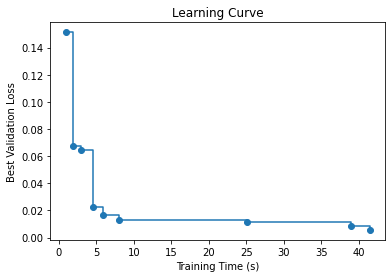

In [7]:
print('Selected Estimator:', automl30.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl30.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl30.best_config_train_time))
print()

y_pred30 = automl30.predict(X_test30)
balanced_accuracy = balanced_accuracy_score(y_test30, y_pred30)
print(f'The balanced accuracy on testing data from optimized model is {balanced_accuracy}')

# save the optimized automl object
with open('trained_models/automl_builtin_leaf30.pkl', 'wb') as f:
    pickle.dump(automl30, f, pickle.HIGHEST_PROTOCOL)
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)

## Multiple Estimators for Leaves100

### Optimize with CFO

In [42]:
np.random.seed(10)  # To make sure same code will get the same output from FLAML

automl100 = AutoML()

settings = {
    "time_budget": 600,  
    "metric": 'accuracy',  
    "task": 'multi',     
    "n_splits": 10,
    "split_type": 'stratified',
    "verbose": 0,
    "hpo_method": 'cfo',  # you can choose among ['cfo', 'bs', 'grid']
    "log_file_name": 'logs/automl_builtin_leaf100.log',  
}

automl100.fit(X_train=X_train100, y_train=y_train100, **settings)

Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 24 iterations
Finished loading model, total used 10 iterations
Finished loading model, total used 55 iterations
Finished loading model, total used 36 iterations
Finished loading model, total used 85 iterations


Selected Estimator: LGBMClassifier(colsample_bytree=0.5689279468453852,
               learning_rate=0.08191921779081662, max_bin=16,
               min_child_samples=9, n_estimators=85, num_leaves=12,
               objective='multiclass', reg_alpha=0.0091236219175731,
               reg_lambda=0.8655997153069142)
Best loss on validation data: 0.01407
Training duration of best run: 84.65 s

The balanced accuracy on testing data from optimized model is 0.9133333333333334


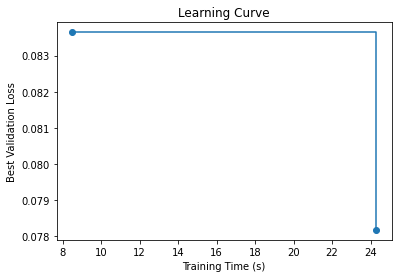

In [43]:
print('Selected Estimator:', automl100.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl100.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl100.best_config_train_time))
print()

y_pred100 = automl100.predict(X_test100)
balanced_accuracy = balanced_accuracy_score(y_test100, y_pred100)
print(f'The balanced accuracy on testing data from optimized model is {balanced_accuracy}')

# save the optimized automl object
with open('trained_models/automl_builtin_leaf100.pkl', 'wb') as f:
    pickle.dump(automl100, f, pickle.HIGHEST_PROTOCOL)
    
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)

### Optimize with Blend Search

In [46]:
np.random.seed(10)  # To make sure same code will get the same output from FLAML

automl100 = AutoML()

settings = {
    "time_budget": 600,  
    "metric": 'accuracy',  
    "task": 'multi',     
    "n_splits": 10,
    "split_type": 'stratified',
    "verbose": 0,
    "hpo_method": 'bs',  # you can choose among ['cfo', 'bs', 'grid']
    "log_file_name": 'logs/automl_builtin_leaf100.log',  
}

automl100.fit(X_train=X_train100, y_train=y_train100, **settings)

You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2021-08-08 22:42:51,585] A new study created in memory with name: optuna


Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations


You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2021-08-08 22:43:03,937] A new study created in memory with name: optuna


Finished loading model, total used 4 iterations


You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2021-08-08 22:43:18,871] A new study created in memory with name: optuna


Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 4 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 15 iterations


You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2021-08-08 22:44:33,437] A new study created in memory with name: optuna


Finished loading model, total used 9 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 15 iterations
Finished loading model, total used 9 iterations
Finished loading model, total used 24 iterations
Finished loading model, total used 10 iterations
Finished loading model, total used 55 iterations
Finished loading model, total used 36 iterations


You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2021-08-08 22:51:48,636] A new study created in memory with name: optuna


Finished loading model, total used 85 iterations


No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'.
You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `config` argument to `tune.run()` instead.
[I 2021-08-08 22:52:50,626] A new study created in memory with name: optuna
C:\Users\wuhan\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Selected Estimator: LGBMClassifier(colsample_bytree=0.5689279468453852,
               learning_rate=0.08191921779081662, max_bin=16,
               min_child_samples=9, n_estimators=85, num_leaves=12,
               objective='multiclass', reg_alpha=0.0091236219175731,
               reg_lambda=0.8655997153069142)
Best loss on validation data: 0.01407
Training duration of best run: 123.8 s

The balanced accuracy on testing data from optimized model is 0.8958333333333335


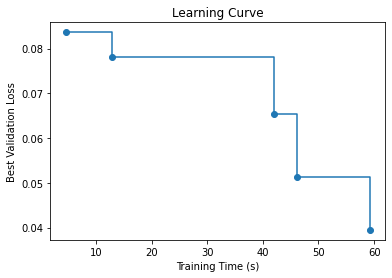

In [47]:
print('Selected Estimator:', automl100.model.estimator)
print('Best loss on validation data: {0:.4g}'.format(automl100.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl100.best_config_train_time))
print()

y_pred100 = automl100.predict(X_test100)
balanced_accuracy = balanced_accuracy_score(y_test100, y_pred100)
print(f'The balanced accuracy on testing data from optimized model is {balanced_accuracy}')

# save the optimized automl object
with open('trained_models/automl_builtin_leaf100.pkl', 'wb') as f:
    pickle.dump(automl100, f, pickle.HIGHEST_PROTOCOL)
    
    
# plot FLAML learning curve
training_time_list, best_error_list, error_list, config_list, logged_metric_list = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=60)

plot_learning_curve(training_time_list, best_error_list)

## Experiments Notes

* By defult, FLAML is using CFO as the `hpo_method`
  * You can specify `hpo_method` as 'cfo' or 'bs' (BlendSearch) or 'grid'. 
  * It seems that you can also set it as 'optuna', but I got errors with this seeting. FLAML was still a new tool in 2021 at the time when I was experimenting on it, multiple things were still under development.
  * You can chat in their glitter to ask questions and help them improve: https://gitter.im/FLAMLer/community
* I could not set seed or random_state through `automl` `settings`, and got different performance results with the same code. To resolve this issue, as FLAML team suggested, need to add `np.random.seed([seed])` before initiating automl through `AutoML()`
* When your time budget is too small and the result could not converge, FLAML output will notify that if your `verbose` >= 1